In [1]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_squared_error
import numpy as np


In [3]:
df = pd.read_pickle("Project-3_NYC_311_Calls.pkl")


In [4]:
# The average number of daily complaints received in 2022

df['Created Date'] = pd.to_datetime(df['Created Date'])

df_2022 = df[df['Created Date'].dt.year == 2022]

daily_complaints = df_2022.resample('D', on='Created Date').count()

average_daily_complaints = daily_complaints['Unique Key'].mean()

print(f"The average number of daily complaints in 2022 was: {average_daily_complaints}")


The average number of daily complaints in 2022 was: 8684.320547945206


In [3]:
# On which single date were the maximum number of calls received?


df['Created Date'] = pd.to_datetime(df['Created Date'])

# Resample to get daily counts of complaints
daily_complaints = df.resample('D', on='Created Date').count()

# Find the date with the maximum number of complaints
max_complaints_date = daily_complaints['Unique Key'].idxmax()
max_complaints_value = daily_complaints['Unique Key'].max()

print(f"The maximum number of calls received was on {max_complaints_date.date()} with {max_complaints_value} calls.")

The maximum number of calls received was on 2020-08-04 with 24415 calls.


In [4]:
# The most important complaint type on the date the maximum number of calls were received


df['Created Date'] = pd.to_datetime(df['Created Date'])

daily_complaints = df.resample('D', on='Created Date').count()

max_complaints_date = daily_complaints['Unique Key'].idxmax()

df_max_date = df[df['Created Date'].dt.date == max_complaints_date.date()]

most_common_complaint = df_max_date['Complaint Type'].value_counts().idxmax()
complaint_count = df_max_date['Complaint Type'].value_counts().max()

print(f"On {max_complaints_date.date()}, the most common complaint type was '{most_common_complaint}' with {complaint_count} occurrences.")


On 2020-08-04, the most common complaint type was 'Damaged Tree' with 14863 occurrences.


In [5]:
# Quietest month: Group the data by months, and identify the month that historically has the fewest number of calls.

df['Created Date'] = pd.to_datetime(df['Created Date'])

monthly_complaints = df.groupby(df['Created Date'].dt.month).count()

quietest_month = monthly_complaints['Unique Key'].idxmin()
quietest_month_count = monthly_complaints['Unique Key'].min()

import calendar
month_name = calendar.month_name[quietest_month]

print(f"The quietest month historically is {month_name} with {quietest_month_count} calls.")


The quietest month historically is December with 2596986 calls.


In [6]:
# Resample the time series to a daily frequency.  
# Perform ETS decomposition based on an additive model.  
# The value of the seasonal component on 2020-12-25 


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# Load your dataset
df = pd.read_pickle("Project-3_NYC_311_Calls.pkl")

df['Created Date'] = pd.to_datetime(df['Created Date'])

# Resample the data to daily frequency, counting the number of complaints per day
daily_data = df.resample('D', on='Created Date').count()['Unique Key']

# Perform ETS decomposition on the daily data
decomposition = seasonal_decompose(daily_data, model='additive', period=365)  # Assuming yearly seasonality

# Extract the seasonal component
seasonal = decomposition.seasonal

# Find the seasonal component for December 25, 2020
seasonal_value = seasonal['2020-12-25']

print(f"The seasonal component on 2020-12-25 is approximately {round(seasonal_value)}")



The seasonal component on 2020-12-25 is approximately -1106


In [8]:
# The autocorrelation of the number of daily calls with the number of calls the day prior, ie lag of 1.

 
df['Created Date'] = pd.to_datetime(df['Created Date'])

daily_data = df.resample('D', on='Created Date').count()['Unique Key']

# Calculate autocorrelation with a lag of 1
autocorrelation_lag_1 = daily_data.autocorr(lag=1)

print(f"The autocorrelation of the number of daily calls with the number of calls the day prior (lag of 1) is: {autocorrelation_lag_1}")


The autocorrelation of the number of daily calls with the number of calls the day prior (lag of 1) is: 0.7517059728398577


In [12]:
# Forecast the daily series with a test set of 90 days using the Prophet library. 
# RMSE on the test set?



# Resample the data to daily frequency, counting the number of complaints per day
df_daily = df.resample('D', on='Created Date').count()['Unique Key'].reset_index()
df_daily.columns = ['ds', 'y']


In [13]:
# Define the point to split the data - last 90 days as test set
split_date = df_daily['ds'].max() - pd.Timedelta(days=90)

# Create training and test sets
train = df_daily[df_daily['ds'] <= split_date]
test = df_daily[df_daily['ds'] > split_date]

In [14]:
# Initialize the Model
model = Prophet()
model.fit(train)

20:36:33 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# Make a dataframe for predictions
future = test.drop('y', axis=1)

# Use the model to make predictions
forecast = model.predict(future)

In [16]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['y'], forecast['yhat']))
print(f"RMSE on the test set is: {rmse}")


RMSE on the test set is: 1233.7312313093698


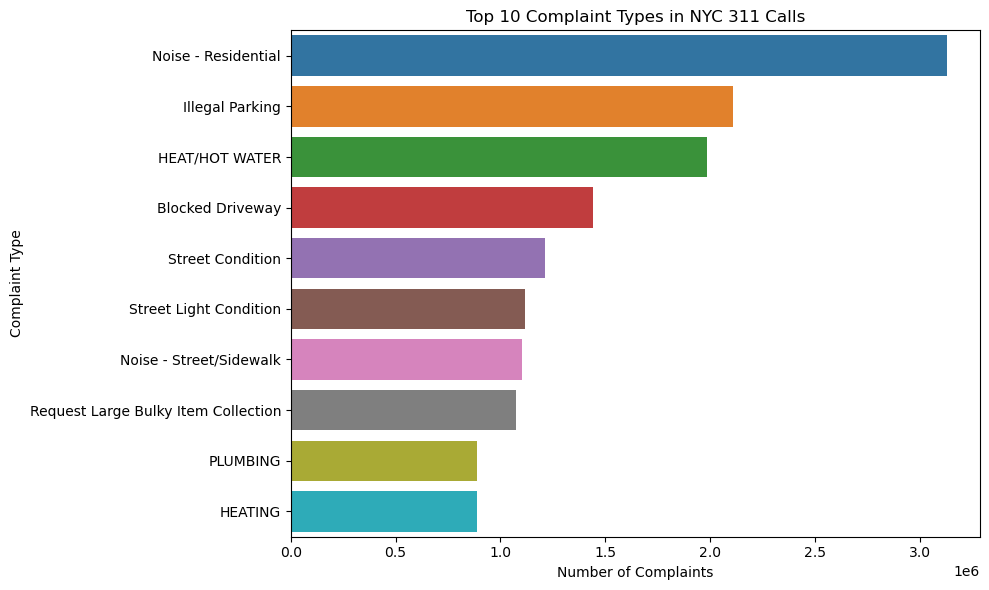

In [5]:
# Top 10 Complaint Types in NYC 311 Calls

import seaborn as sns
import matplotlib.pyplot as plt

top_complaints = df['Complaint Type'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_complaints.values, y=top_complaints.index)
plt.title('Top 10 Complaint Types in NYC 311 Calls')
plt.xlabel('Number of Complaints')
plt.ylabel('Complaint Type')
plt.tight_layout()
plt.show()

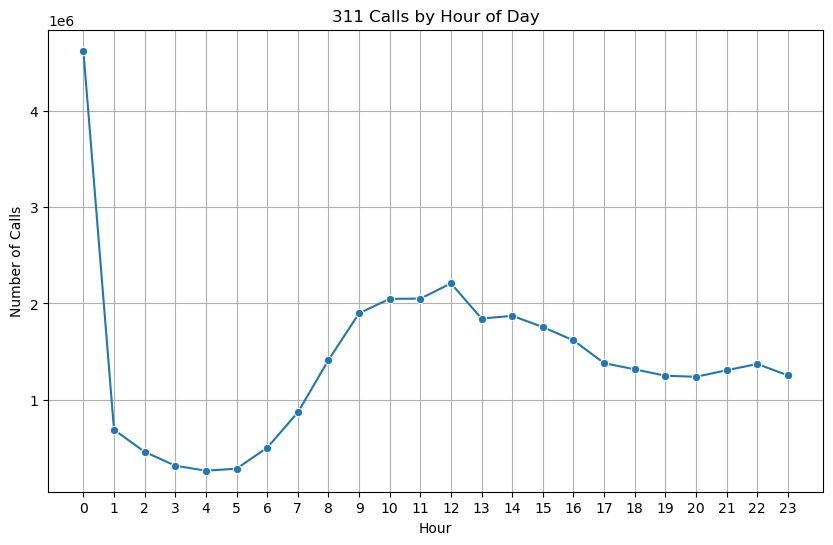

In [6]:
#Calls by Hour of Day

df['Hour'] = pd.to_datetime(df['Created Date']).dt.hour
hourly_counts = df['Hour'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o')
plt.title('311 Calls by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Calls')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

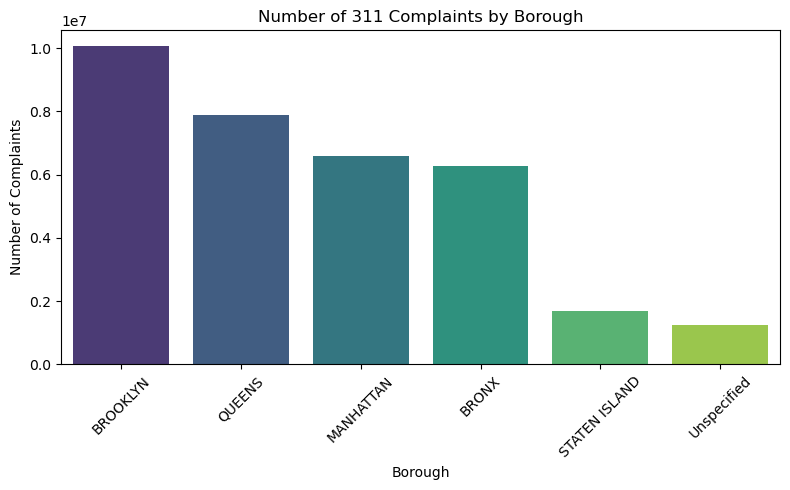

In [10]:
#Number of 311 Complaints by Borough

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count complaints by borough
borough_counts = df['Borough'].value_counts().sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=borough_counts.index, y=borough_counts.values, palette='viridis')

plt.title("Number of 311 Complaints by Borough")
plt.xlabel("Borough")
plt.ylabel("Number of Complaints")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()